**Primeiro, vamos criar nosso ambiente virtual:**

```shell
virtualenv -p python3.12 env && source env/bin/activate
```

**Instalando nossas dependências:**

In [1]:
pip install networkx numpy requests matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


**Vamos iniciar nosso código:**

In [12]:
import networkx as nx
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

TOP_K = 3 # a quatidade de nós/documentos principais a serem retornados
MIN_SIM = 0.7 # o mínimo de similaridade aceitável na aplicação
documents = [
    "Clientes podem pagar com cartão de crédito em até 6 vezes sem juros.",
    "Aceitamos Pix como forma de pagamento instantâneo.",
    "Compras com boleto bancário podem levar até 3 dias úteis para compensação.",
    "Para pagar com cartão de débito, selecione a opção no checkout.",
    "Os pagamentos com cartão passam por análise antifraude automática.",
    "Nosso site é o http://xuxu.com.br",
    "Compras são feitas pelo nosso site e enviamos para todo Brasil.",
    
    "Trocas são aceitas em até 7 dias após o recebimento do produto.",
    "Para iniciar uma devolução, acesse sua conta e selecione a compra.",
    "O produto precisa estar sem sinais de uso e com embalagem original.",
    "A primeira troca é gratuita, exceto em produtos promocionais.",
    "O reembolso será feito após análise do item devolvido, em até 10 dias.",
    
    "Entregamos para todo o Brasil com prazo de 3 a 10 dias úteis.",
    "Frete grátis disponível para compras acima de R$200.",
    "Você pode acompanhar seu pedido usando o código de rastreamento enviado por e-mail.",
    "Pedidos com problemas de entrega devem ser informados ao suporte.",
    "Ajustes no endereço só são aceitos antes da confirmação do envio.",
    
    "Os sapatos da linha esportiva são ideais para academia e caminhadas.",
    "A linha social oferece modelos elegantes para eventos e trabalho.",
    "Nossos calçados veganos não utilizam nenhum material de origem animal.",
    "Modelos em couro legítimo recebem tratamento especial contra ressecamento.",
    "Palmilhas e cadarços estão disponíveis como acessórios avulsos."
]

print(f"Configurações e Dados Carregados!\n\nTOP_K: {TOP_K}\nMIN_SIM: {MIN_SIM}\ndocuments: {documents}")

Configurações e Dados Carregados!

TOP_K: 3
MIN_SIM: 0.7
documents: ['Clientes podem pagar com cartão de crédito em até 6 vezes sem juros.', 'Aceitamos Pix como forma de pagamento instantâneo.', 'Compras com boleto bancário podem levar até 3 dias úteis para compensação.', 'Para pagar com cartão de débito, selecione a opção no checkout.', 'Os pagamentos com cartão passam por análise antifraude automática.', 'Nosso site é o http://xuxu.com.br', 'Compras são feitas pelo nosso site e enviamos para todo Brasil.', 'Trocas são aceitas em até 7 dias após o recebimento do produto.', 'Para iniciar uma devolução, acesse sua conta e selecione a compra.', 'O produto precisa estar sem sinais de uso e com embalagem original.', 'A primeira troca é gratuita, exceto em produtos promocionais.', 'O reembolso será feito após análise do item devolvido, em até 10 dias.', 'Entregamos para todo o Brasil com prazo de 3 a 10 dias úteis.', 'Frete grátis disponível para compras acima de R$200.', 'Você pode acompan

**Agora, vamos definir a nossa função de embeddings e guardar os embeddings dos documentos em uma variável.**

In [14]:
def get_embedding(texts):
    # Envia os textos para a API local do modelo de embedding (nomic-embed-text)
    response = requests.post(
        "http://localhost:11434/api/embed",
        json={"model": "nomic-embed-text", "input": texts}
    )
    
    # Garante que a resposta foi bem-sucedida, senão lança um erro
    response.raise_for_status()
    
    # Extrai os vetores da resposta e converte para um array NumPy
    vectors = np.array(response.json()["embeddings"])
    
    # Normaliza os vetores para ter norma 1
    return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

# Gera e armazena os embeddings normalizados de todos os documentos
embeddings = get_embedding(documents)

print(f"embeddings: {embeddings}")

embeddings: [[ 0.03149717  0.09237922 -0.16050887 ... -0.02521573  0.0003523
   0.00861666]
 [ 0.05911777  0.0702008  -0.15378128 ... -0.06046053 -0.01205934
  -0.01825341]
 [ 0.02706308  0.09695442 -0.16460989 ... -0.04014988 -0.01737847
  -0.01992642]
 ...
 [ 0.05672079  0.08480772 -0.14102514 ... -0.07460303 -0.05852389
   0.00148591]
 [ 0.01131468  0.05811519 -0.15741148 ... -0.08115546 -0.01576314
   0.01016646]
 [ 0.06631773  0.05499673 -0.13819973 ... -0.05187204 -0.05958005
  -0.02071888]]


**Agora, com os embeddings normalizados dos nossos documentos, vamos montar o nosso grafo. Por partes, primeiro vamos montar os nós principais:**

In [17]:
# Cria um grafo não direcionado vazio usando NetworkX
graph = nx.Graph()

# Adiciona cada documento como um nó no grafo, usando o índice do laço como ID e o texto como atributo
for i, doc in enumerate(documents):
    graph.add_node(i, text=doc)

print(f"grafo: {graph}\n\nnós: {list(graph.nodes)}")

grafo: Graph with 22 nodes and 0 edges

nós: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


**Agora, delimitamos as arestas no grafo:**

In [18]:
# Laço duplo para comparar todos os pares de documentos e montar as arestas do grafo
for i in range(len(documents)):
    for j in range(i + 1, len(documents)):  # Evita repetir comparações e auto-similaridade
        sim = np.dot(embeddings[i], embeddings[j]) # calcula a similaridade entre dois vetores
        if sim >= MIN_SIM:  # Cria aresta apenas se a similaridade for maior ou igual ao limiar definido
            graph.add_edge(i, j, weight=sim)

print(f"arestas: {list(graph.edges)}")

arestas: [(0, 2), (2, 6), (2, 8), (2, 12), (5, 6), (6, 8), (6, 12), (7, 10), (7, 11), (8, 9), (8, 10), (8, 11), (8, 15), (11, 12), (18, 20)]


**Agora, a etapa de criação do nosso grafo está pronta e precisamos de uma visão dele:**

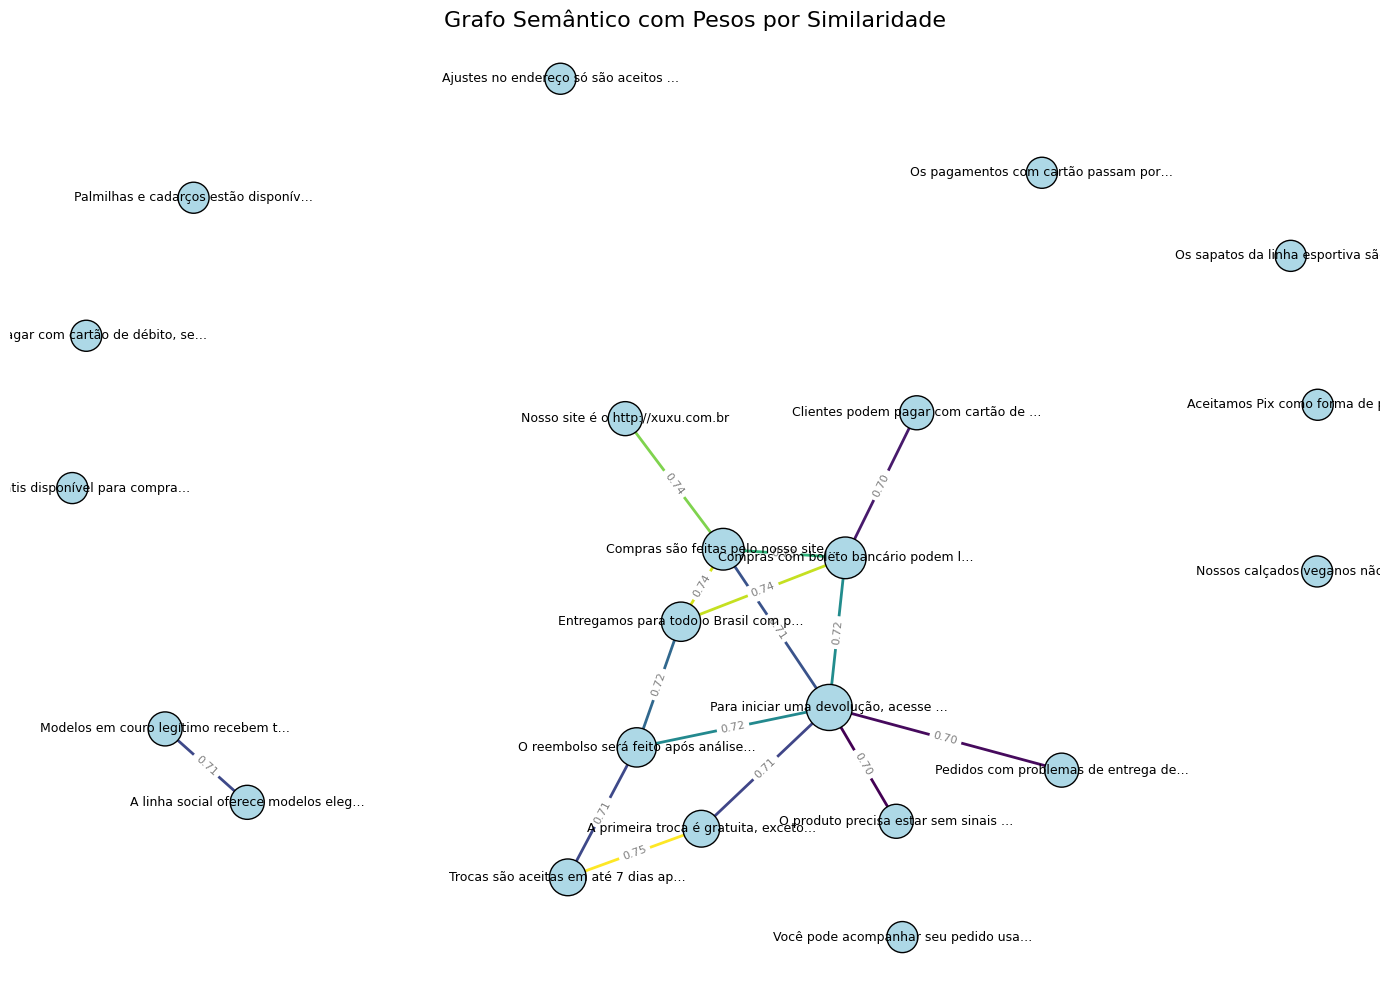

In [21]:
def plot_graph(graph):
    plt.figure(figsize=(14, 10))  # Define o tamanho da figura
    pos = nx.spring_layout(graph, seed=42, k=0.5)  # Calcula posições dos nós com layout de mola

    # Calcula o grau de cada nó e ajusta o tamanho dos nós proporcionalmente
    degrees = dict(graph.degree())
    node_sizes = [500 + 100 * degrees[n] for n in graph.nodes()]

    # Coleta pesos das arestas para definir cores
    edges = graph.edges(data=True)
    weights = [attr['weight'] for _, _, attr in edges]
    min_w, max_w = min(weights), max(weights)
    edge_colors = [plt.cm.viridis((w - min_w) / (max_w - min_w)) for w in weights]

    # Limita o texto exibido em cada nó a 35 caracteres
    labels = {
        i: (graph.nodes[i]["text"][:35] + "…") if len(graph.nodes[i]["text"]) > 35 else graph.nodes[i]["text"]
        for i in graph.nodes()
    }

    # Desenha os nós
    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color='lightblue', edgecolors='black')

    # Desenha os rótulos dos nós
    nx.draw_networkx_labels(graph, pos, labels, font_size=9)

    # Desenha as arestas com cores baseadas no peso
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, width=2)

    # Adiciona rótulos de peso nas arestas
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels, font_color='gray', font_size=8)

    # Título e layout
    plt.title("Grafo Semântico com Pesos por Similaridade", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_graph(graph)

**Outra visualização interessante é a matriz de adjacência do nosso grafo**

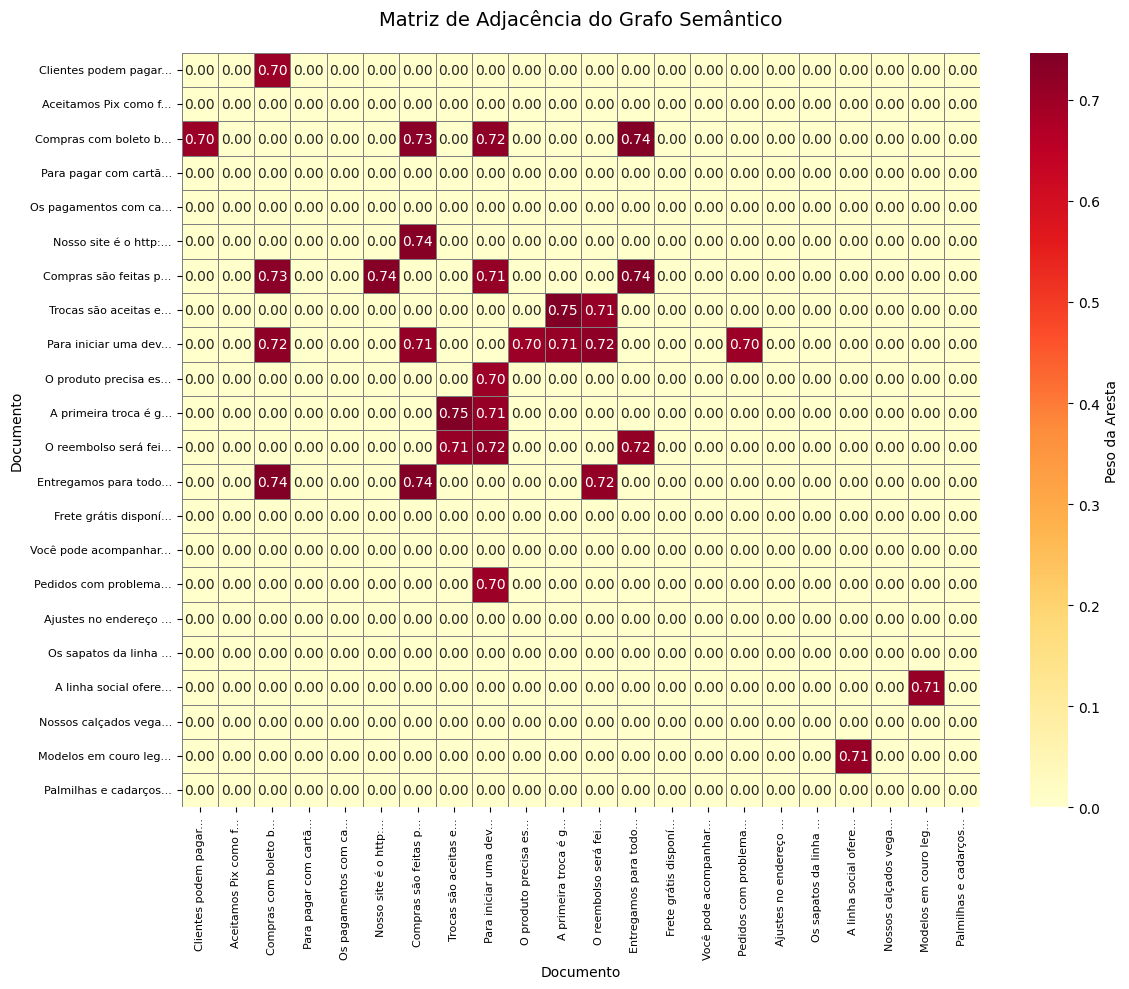

In [22]:
def plot_graph_adjacency_matrix(graph):
    adj = nx.to_numpy_array(graph, weight='weight')
    num_nodes = graph.number_of_nodes()

    # Gera os rótulos com o início do texto de cada documento
    labels = [graph.nodes[i]['text'][:20] + '...' if len(graph.nodes[i]['text']) > 20 else graph.nodes[i]['text'] 
              for i in range(num_nodes)]
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        adj, 
        cmap='YlOrRd',  # paleta de cor em tons quentes
        annot=True,      # mostra os valores dentro das células
        fmt=".2f",       # formatação com 2 casas decimais
        cbar_kws={'label': 'Peso da Aresta'},
        xticklabels=labels,
        yticklabels=labels,
        linewidths=0.5,
        linecolor='gray'
    )
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.title('Matriz de Adjacência do Grafo Semântico', fontsize=14, pad=20)
    plt.xlabel('Documento')
    plt.ylabel('Documento')
    plt.tight_layout()
    plt.show()

plot_graph_adjacency_matrix(graph)

**Agora, vamos iniciar nosso fluxo RAG**

**Primeiro, o retrieve:**

In [23]:
def rag_query(query, top_k=TOP_K, min_edge_weight=MIN_SIM):
    query_emb = get_embedding([query])[0]
    similarities = [np.dot(query_emb, doc_emb) for doc_emb in embeddings]

    # Top K documentos mais similares à query
    top_k_indices = np.argsort(similarities)[::-1][:top_k]

    # Coleta nós principais + seus vizinhos
    context_ids = set()
    for idx in top_k_indices:
        context_ids.add(idx)
        for neighbor in graph.neighbors(idx):
            if graph[idx][neighbor]['weight'] >= min_edge_weight:
                context_ids.add(neighbor)

    # Coleta os textos correspondentes
    context = [graph.nodes[i]['text'] for i in context_ids]

    print(f"\n🔎 Resultado da busca com grafo (sementes = {list(top_k_indices)}):")
    for i in context_ids:
        print(f"- {graph.nodes[i]['text']}")

    return "\n".join(context)

**Agora, vamos criar a chamada ao modelo de linguagem:**

In [24]:
def generate_response(prompt):
    payload = {
        "model": "llama3",
        "prompt": prompt,
        "stream": False,
    } # payload para envio ao Ollama
    response = requests.post("http://localhost:11434/api/generate", json=payload) # post com o prompt
    response.raise_for_status() # retorna um erro em caso de insucesso na requisição
    return response.json()["response"] # retorna apenas a resposta do modelo

**Vamos definir nossa pergunta:**

In [25]:
query = "É possível fazer Alterações no endereço depois de finalizar a compra? Se sim, como fazer?"

**Agora, vamos recuperar os documentos semelhantes da nossa base:**

In [27]:
context = rag_query(query)


🔎 Resultado da busca com grafo (sementes = [np.int64(8), np.int64(16), np.int64(9)]):
- Compras com boleto bancário podem levar até 3 dias úteis para compensação.
- Compras são feitas pelo nosso site e enviamos para todo Brasil.
- Para iniciar uma devolução, acesse sua conta e selecione a compra.
- O produto precisa estar sem sinais de uso e com embalagem original.
- A primeira troca é gratuita, exceto em produtos promocionais.
- O reembolso será feito após análise do item devolvido, em até 10 dias.
- Pedidos com problemas de entrega devem ser informados ao suporte.
- Ajustes no endereço só são aceitos antes da confirmação do envio.


**Vamos ver essa relação?**

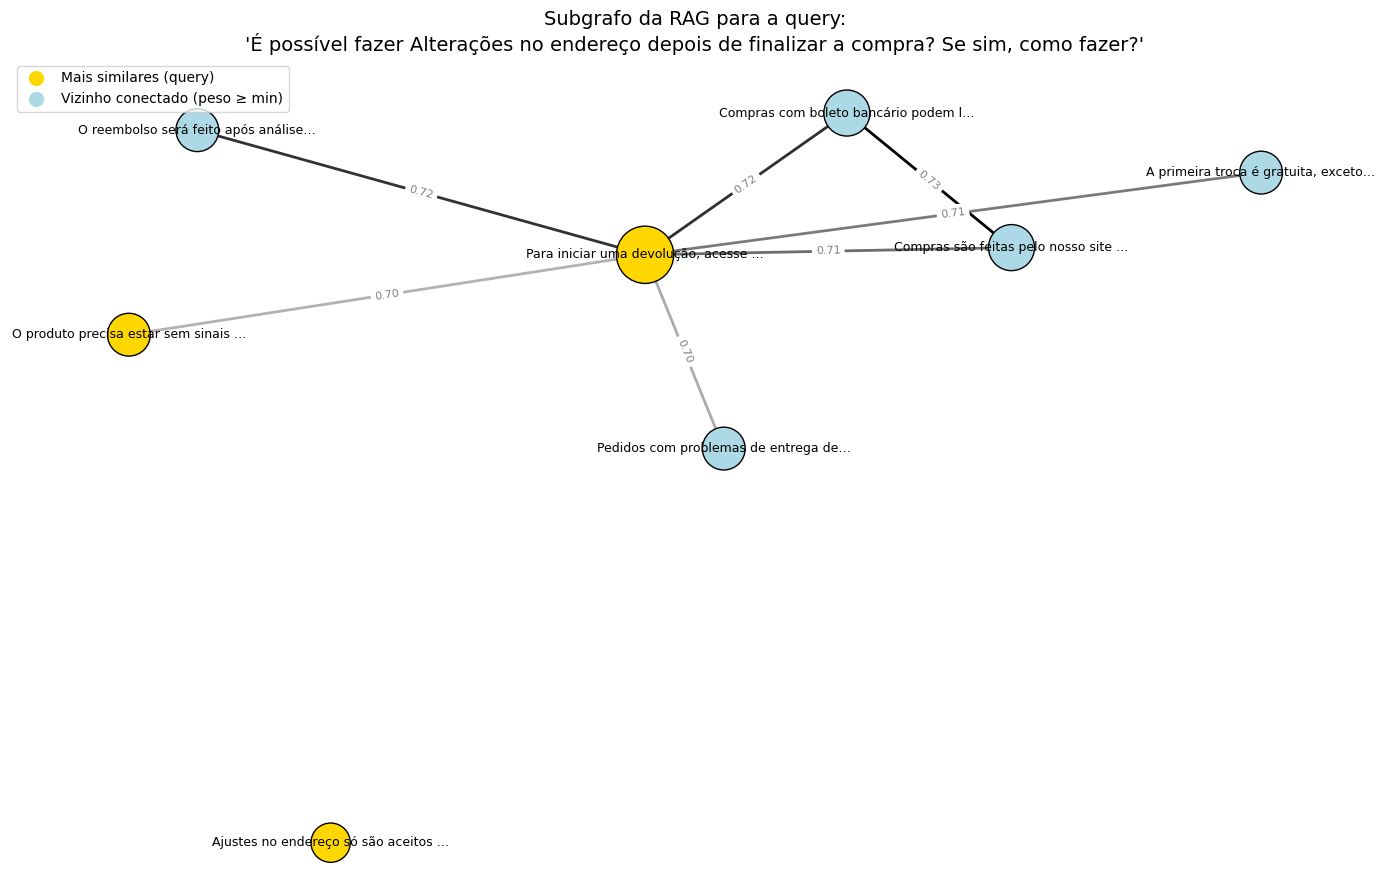

In [30]:
def plot_query_subgraph(query, top_k=TOP_K, min_edge_weight=MIN_SIM):
    query_emb = get_embedding([query])[0]
    similarities = [np.dot(query_emb, doc_emb) for doc_emb in embeddings]

    # Top K mais similares
    top_k_indices = np.argsort(similarities)[::-1][:top_k]
    main_nodes = set(top_k_indices)

    # Adiciona vizinhos com peso acima do mínimo
    context_nodes = set(main_nodes)
    for idx in top_k_indices:
        for neighbor in graph.neighbors(idx):
            if graph[idx][neighbor]['weight'] >= min_edge_weight:
                context_nodes.add(neighbor)

    subgraph = graph.subgraph(context_nodes).copy()
    pos = nx.spring_layout(subgraph, seed=42, k=0.7)

    # Cores e tamanhos
    node_colors = ['gold' if node in main_nodes else 'lightblue' for node in subgraph.nodes()]
    node_sizes = [800 + 150 * subgraph.degree(n) for n in subgraph.nodes()]

    # Desenho do grafo
    plt.figure(figsize=(14, 9))
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black')

    # Rótulos
    labels = {
        n: f"{graph.nodes[n]['text'][:35]}…" if len(graph.nodes[n]['text']) > 35 else graph.nodes[n]['text']
        for n in subgraph.nodes()
    }
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=9)

    # Arestas com transparência proporcional ao peso
    edges = subgraph.edges(data=True)
    weights = [d['weight'] for _, _, d in edges] if edges else []
    if weights:
        min_w, max_w = min(weights), max(weights)
        alphas = [0.3 + 0.7 * (w - min_w) / (max_w - min_w) if max_w > min_w else 1 for w in weights]
        edge_colors = [(0, 0, 0, alpha) for alpha in alphas]
    else:
        edge_colors = []

    nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, width=2)

    # Rótulos das arestas
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels, font_size=8, font_color='gray')

    # Legenda
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Mais similares (query)', markerfacecolor='gold', markersize=12),
        plt.Line2D([0], [0], marker='o', color='w', label='Vizinho conectado (peso ≥ min)', markerfacecolor='lightblue', markersize=12)
    ]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=10)

    plt.title(f"Subgrafo da RAG para a query:\n'{query}'", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_query_subgraph(query, top_k=TOP_K, min_edge_weight=MIN_SIM)

**Dessa forma, possuímos as duas informações que precisamos para montar o nosso prompt.**

In [32]:
def prompt():

    full_prompt = f"""
    Você é empresa Xuxu.
    Você responde **apenas** a perguntas sobre você.
    **Nunca** responde sobre perguntas relacionadas a outras empresas. 
    **Nunca** inventa informações, dados ou qualquer coisa que não esteja no cotexto que você recebeu. 
    Se o contexto recebido for igual a "Nenhum contexto relevante encontrado.", **informe** **apenas** que não tem conhecimento suficiente para responder.
    Use o contexto abaixo para responder à pergunta:
    {context}
    Pergunta: {query}
    Resposta:"""

    print(f"Nosso prompt final: \n{full_prompt}\n")

    return full_prompt

In [35]:
def response_from_llm():
    print(f"Resposta gerada:\n{generate_response(prompt())}")

In [36]:
response_from_llm()

Nosso prompt final: 

    Você é empresa Xuxu.
    Você responde **apenas** a perguntas sobre você.
    **Nunca** responde sobre perguntas relacionadas a outras empresas. 
    **Nunca** inventa informações, dados ou qualquer coisa que não esteja no cotexto que você recebeu. 
    Se o contexto recebido for igual a "Nenhum contexto relevante encontrado.", **informe** **apenas** que não tem conhecimento suficiente para responder.
    Use o contexto abaixo para responder à pergunta:
    Compras com boleto bancário podem levar até 3 dias úteis para compensação.
Compras são feitas pelo nosso site e enviamos para todo Brasil.
Para iniciar uma devolução, acesse sua conta e selecione a compra.
O produto precisa estar sem sinais de uso e com embalagem original.
A primeira troca é gratuita, exceto em produtos promocionais.
O reembolso será feito após análise do item devolvido, em até 10 dias.
Pedidos com problemas de entrega devem ser informados ao suporte.
Ajustes no endereço só são aceitos ante

**1. Vamos perguntar “Preciso comprar papel de impressão. Me ajuda?”**

In [45]:
query = "Preciso comprar papel de impressão. Me ajuda?"

In [46]:
context = rag_query(query)


🔎 Resultado da busca com grafo (sementes = [np.int64(6), np.int64(8), np.int64(13)]):
- Compras com boleto bancário podem levar até 3 dias úteis para compensação.
- Nosso site é o http://xuxu.com.br
- Compras são feitas pelo nosso site e enviamos para todo Brasil.
- Para iniciar uma devolução, acesse sua conta e selecione a compra.
- O produto precisa estar sem sinais de uso e com embalagem original.
- A primeira troca é gratuita, exceto em produtos promocionais.
- O reembolso será feito após análise do item devolvido, em até 10 dias.
- Entregamos para todo o Brasil com prazo de 3 a 10 dias úteis.
- Frete grátis disponível para compras acima de R$200.
- Pedidos com problemas de entrega devem ser informados ao suporte.


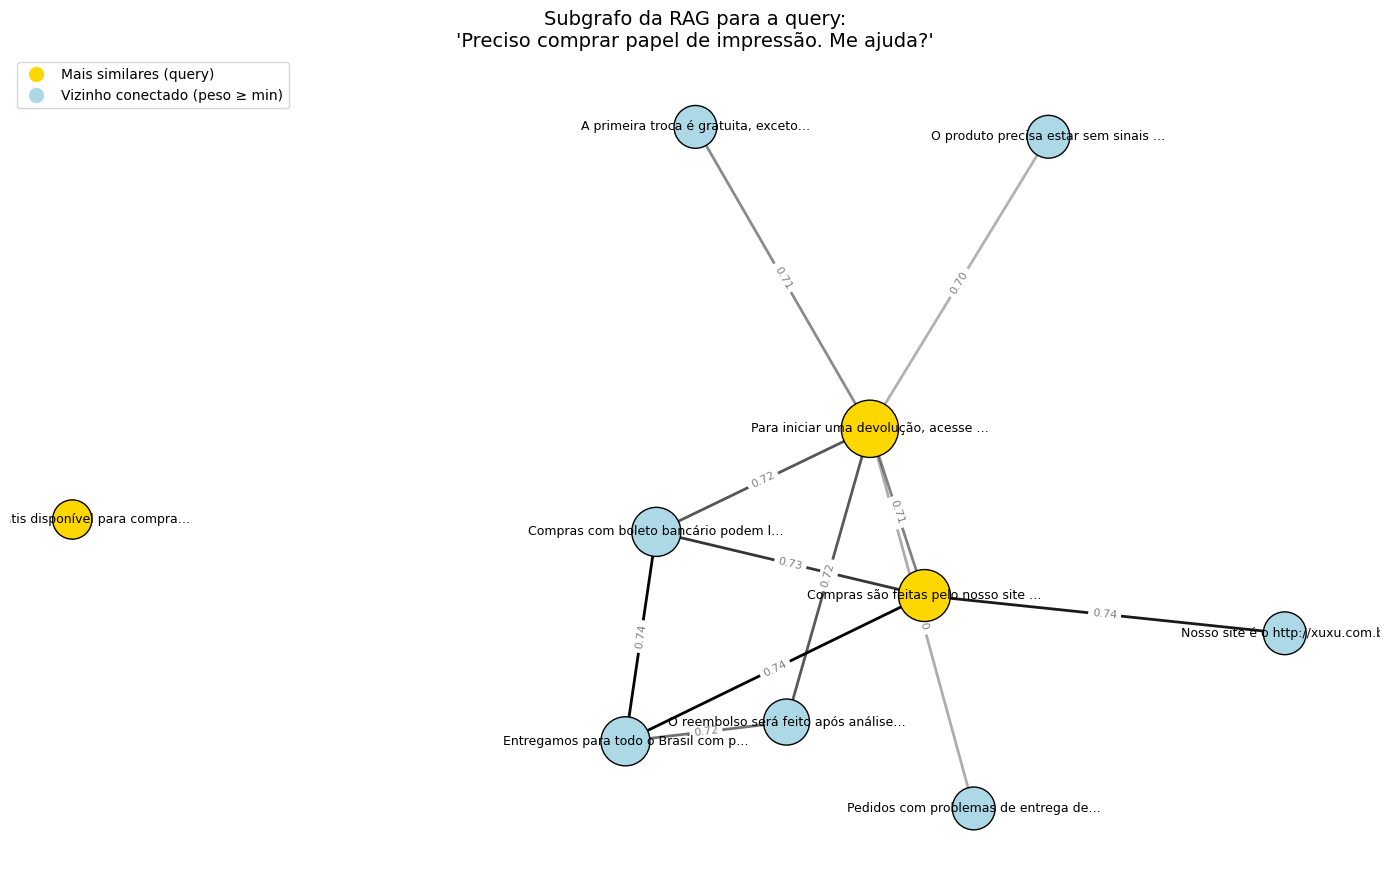

In [47]:
plot_query_subgraph(query, top_k=TOP_K, min_edge_weight=MIN_SIM)

In [44]:
response_from_llm()

Nosso prompt final: 

    Você é empresa Xuxu.
    Você responde **apenas** a perguntas sobre você.
    **Nunca** responde sobre perguntas relacionadas a outras empresas. 
    **Nunca** inventa informações, dados ou qualquer coisa que não esteja no cotexto que você recebeu. 
    Se o contexto recebido for igual a "Nenhum contexto relevante encontrado.", **informe** **apenas** que não tem conhecimento suficiente para responder.
    Use o contexto abaixo para responder à pergunta:
    Clientes podem pagar com cartão de crédito em até 6 vezes sem juros.
Aceitamos Pix como forma de pagamento instantâneo.
Compras com boleto bancário podem levar até 3 dias úteis para compensação.
Compras são feitas pelo nosso site e enviamos para todo Brasil.
Para iniciar uma devolução, acesse sua conta e selecione a compra.
Entregamos para todo o Brasil com prazo de 3 a 10 dias úteis.
Nossos calçados veganos não utilizam nenhum material de origem animal.
    Pergunta: batata
    Resposta:

Resposta gerada:


**2. Vamos passar a palavra “batata”**

In [48]:
query = "batata"

In [49]:
context = rag_query(query)


🔎 Resultado da busca com grafo (sementes = [np.int64(2), np.int64(19), np.int64(1)]):
- Clientes podem pagar com cartão de crédito em até 6 vezes sem juros.
- Aceitamos Pix como forma de pagamento instantâneo.
- Compras com boleto bancário podem levar até 3 dias úteis para compensação.
- Compras são feitas pelo nosso site e enviamos para todo Brasil.
- Para iniciar uma devolução, acesse sua conta e selecione a compra.
- Entregamos para todo o Brasil com prazo de 3 a 10 dias úteis.
- Nossos calçados veganos não utilizam nenhum material de origem animal.


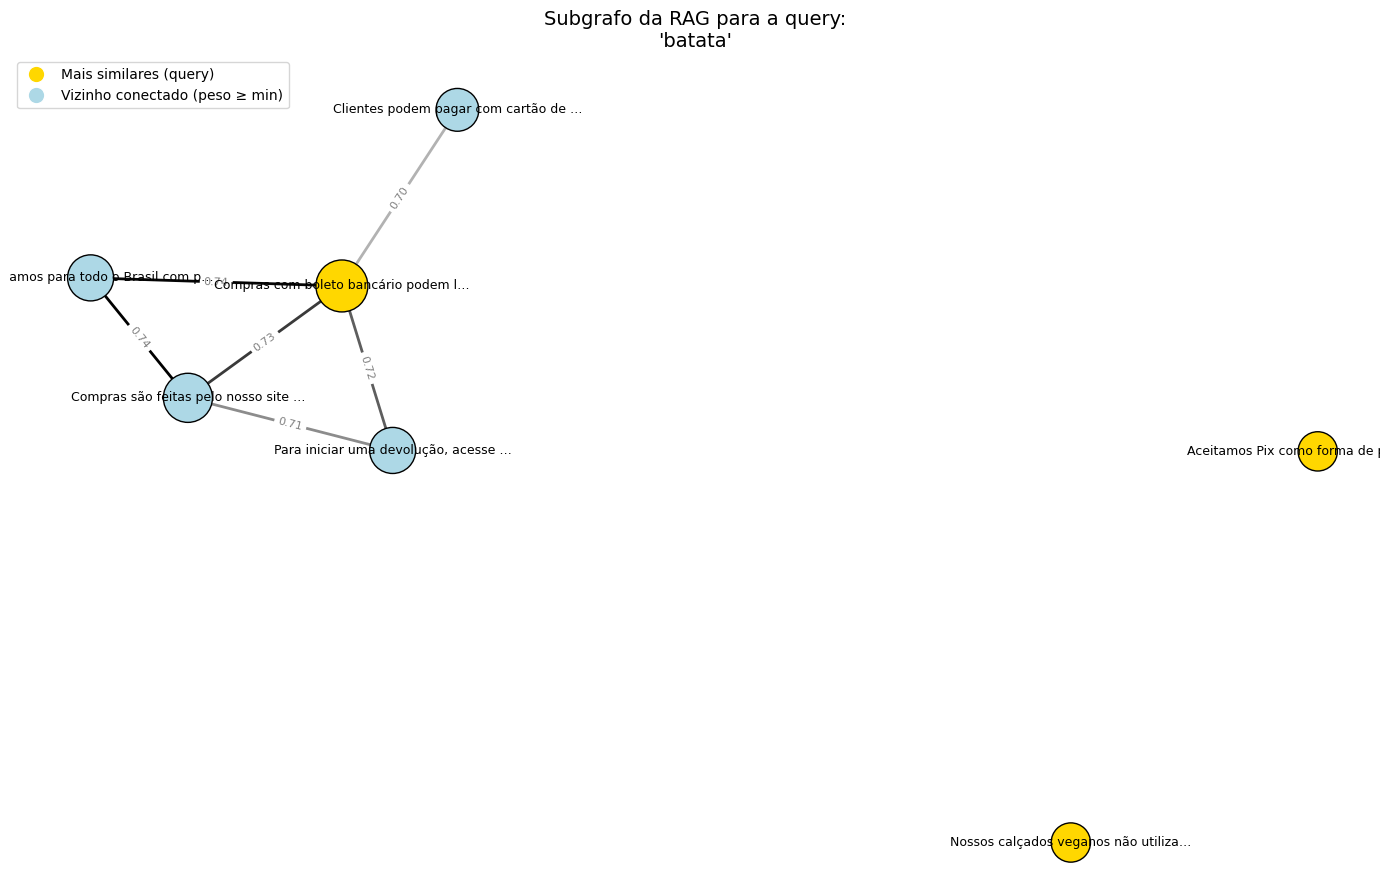

In [50]:
plot_query_subgraph(query, top_k=TOP_K, min_edge_weight=MIN_SIM)

In [51]:
response_from_llm()

Nosso prompt final: 

    Você é empresa Xuxu.
    Você responde **apenas** a perguntas sobre você.
    **Nunca** responde sobre perguntas relacionadas a outras empresas. 
    **Nunca** inventa informações, dados ou qualquer coisa que não esteja no cotexto que você recebeu. 
    Se o contexto recebido for igual a "Nenhum contexto relevante encontrado.", **informe** **apenas** que não tem conhecimento suficiente para responder.
    Use o contexto abaixo para responder à pergunta:
    Clientes podem pagar com cartão de crédito em até 6 vezes sem juros.
Aceitamos Pix como forma de pagamento instantâneo.
Compras com boleto bancário podem levar até 3 dias úteis para compensação.
Compras são feitas pelo nosso site e enviamos para todo Brasil.
Para iniciar uma devolução, acesse sua conta e selecione a compra.
Entregamos para todo o Brasil com prazo de 3 a 10 dias úteis.
Nossos calçados veganos não utilizam nenhum material de origem animal.
    Pergunta: batata
    Resposta:

Resposta gerada:
